# Spatial mapping across the mouse brain - results and downstream analysis

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'

# this line forces theano to use th GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# if using the CPU uncomment this:
#os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'
#os.environ["OMP_NUM_THREADS"] = '8'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location

from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda0` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.    
You should see a message similar to the one below confirming that `theano` started using the GPU:
```
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)
```

## Outline

II. Downstream analysis:

1. Loading cell2location results
2. Visialising cell locations
3. Automatic discrete region identification by clustering cell densities
4. Analyse cell type density gradients using diffusion maps
5. Identify co-occuring cell type combinations using matrix factorisation

## 1. Loading cell2location results

First let's load our cell2location results

In [2]:
results_folder = '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/notebooks/results/mouse_viseum_snrna/'

Results are shown below and saved to:  

In [18]:
results_folder + 'std_model/' + r['run_name']

'/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4V2_50clusters_5396locations_11945genes'

Trained model object can be pulled from `r['mod']`, cell locations are added to `r['sp_data']` as columns of `sp_data.obs` and all paramters of the model are exported to `sp_data.uns['mod']`. This anndata object and a csv file `W.csv` / `W_q05.csv` with cell locations are always saved to the results directory. 

When `'save_model': True`, the trained model `r['mod']` is also saved as a pickle file. You can load the model later and continue training. 

In [21]:
r = {'run_name': 'CoLocationModelNB4V2_50clusters_5396locations_11945genes'}

We load the results of the model saved into the Anndata object with spatial data `adata_vis`:

In [25]:
sp_data_file = results_folder + 'std_model/'+r['run_name']+'/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

Alternatively we can load our model after training (when setting `'save_model':True`; if the training was done on a GPU the model need to be loaded on a GPU):

```python
pickle_model = results_folder + 'std_model/'+r['run_name']+'/model_.p'
r = pickle.load(open(pickle_model, "rb"))

# model
mod = r['mod']

# anndata object with input data and results
adata_vis = r['sp_data']
```

## 2. Visualisation of cell locations

Now we add cell locations to each slide to plot them over histology images.

In [26]:
col_sel = ['mean_nUMI_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['q05_nUMI_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['q95_nUMI_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['mean_spot_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['q05_spot_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['q95_spot_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs

Here we visualise locations of multiple cell types at once.

In [ ]:
from cell2location.plt.mapping_video import plot_contours

# select up to 6 clusters 
sel_clust = ['Oligo_2', 'Inh_Meis2_3', 'Inh_4', 'Ext_Thal_1', 'Ext_L23', 'Ext_L56']
sel_clust_col = ['mean_nUMI_factors' + str(i) for i in sel_clust]
s = 'ST8059048'

rcParams["figure.figsize"] = [15,15]
plot_contours(slides[s].obs[sel_clust_col], 
              coords=slides[s].obsm['spatial'] \
                      * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
              show_img=True, img_alpha=0.8,
              img=list(slides[s].uns['spatial'].values())[0]['images']['hires'],
              circle_diameter=6, alpha_scaling=0.6)

Now we plot the 5% quantile of the posterior distribution on the number of UMI which shows the location only when the model has high confidence.

In [ ]:
# select up to 6 clusters 
sel_clust = ['Oligo_2', 'Inh_Meis2_3', 'Inh_4', 'Ext_Thal_1', 'Ext_L23', 'Ext_L56']
sel_clust_col = ['q05_nUMI_factors' + str(i) for i in sel_clust]
s = 'ST8059048'

rcParams["figure.figsize"] = [15,15]
plot_contours(slides[s].obs[sel_clust_col], 
              coords=slides[s].obsm['spatial'] \
                      * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
              show_img=True, img_alpha=0.8,
              img=list(slides[s].uns['spatial'].values())[0]['images']['hires'],
              circle_diameter=6, alpha_scaling=0.6)

Here we use standard scanpy pipeline to plot cell locations over histology images:

In [ ]:
rcParams["axes.facecolor"] = "white"
rcParams["figure.figsize"] = [10,10]
rcParams["font.size"] = 18

s = 'ST8059048'
sel_clust_col = ['q05_nUMI_factors' in i for i in slides[s].obs.columns]
sel_clust_col = slides[s].obs.columns[sel_clust_col]
from re import sub # create nice names
sel_clust = [sub('q05_nUMI_factors', '', i) for i in sel_clust_col]

# log-transform and save with nice names
slides[s].obs[sel_clust] = np.log10(slides[s].obs[sel_clust_col])

sc.pl.spatial(slides[s], cmap='magma',
              color=sel_clust[0:6], # limit size in this notebook
              ncols=3, 
              size=0.8, img_key='hires', 
              alpha_img=0.5,
              vmin=0, vmax='p99.0'
             )

## 3. Automatic discrete region identification by clustering cell densities
We find regions by clustering spots based on inferred molecule contributions of each cell type. We use standard Leiden clustering. Results are saved in `adata_vis.obs['leiden']`.

In [30]:
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 38)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1)

In [31]:
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster"] =  adata_vis.obs["region_cluster"].astype("category")

Trying to set attribute `.uns` of view, copying.


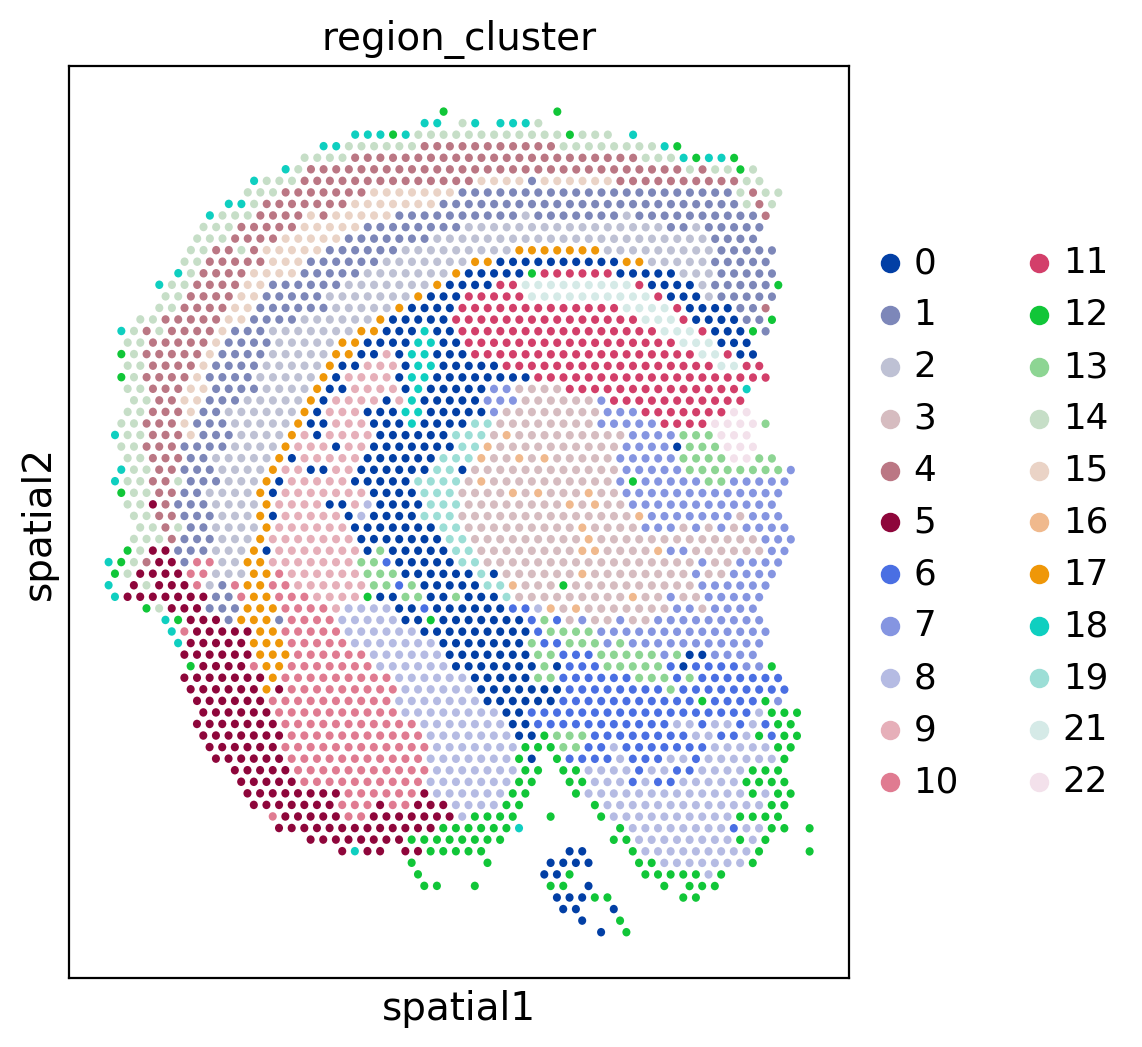

Trying to set attribute `.uns` of view, copying.


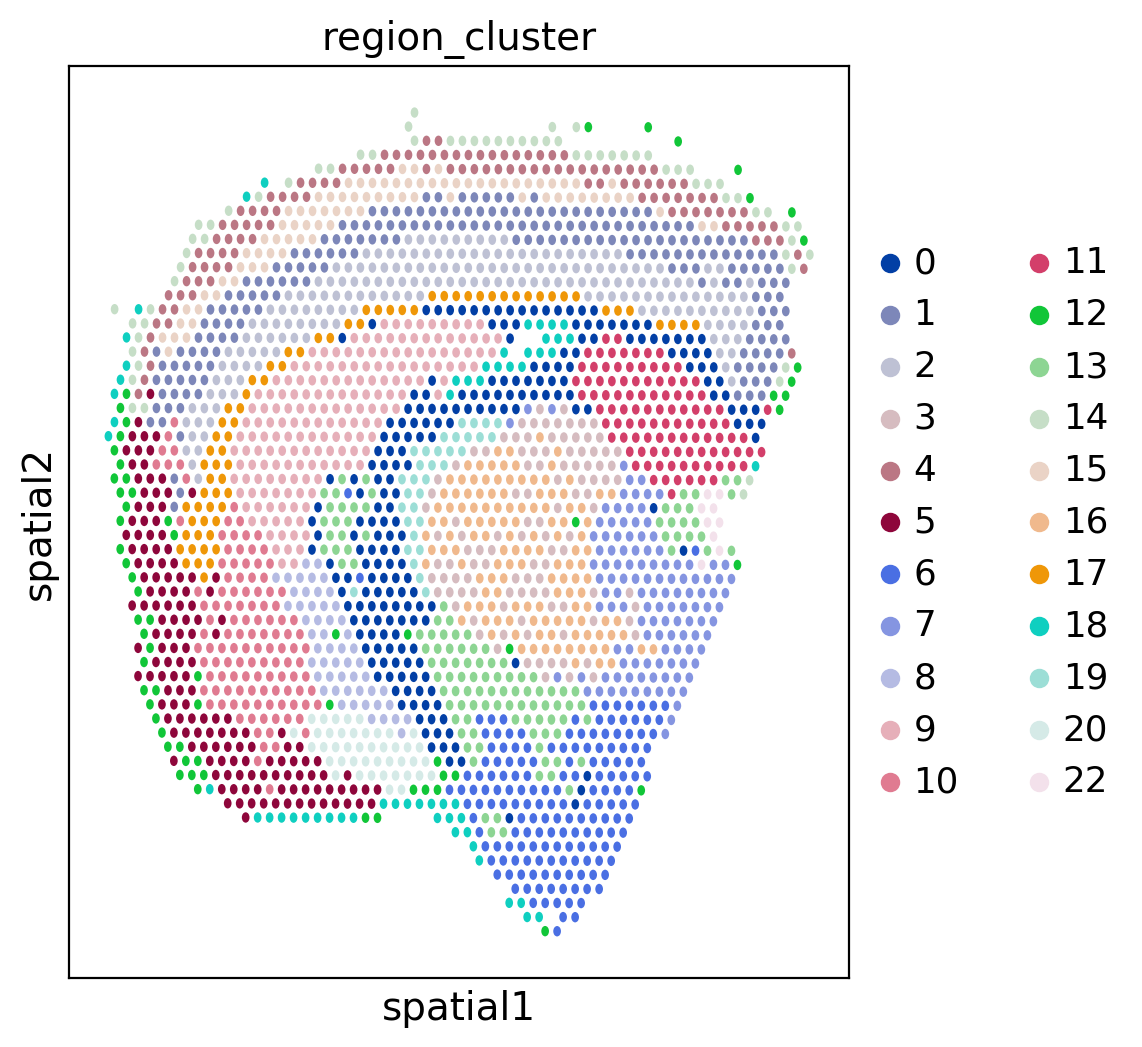

In [32]:
rcParams["figure.figsize"] = [5,6]
rcParams["axes.facecolor"] = "white"
sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059048"], 
              color=["region_cluster"], img_key=None
            );
sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059051"], 
              color=["region_cluster"], img_key=None
            )

### Export regions for import to 10X Loupe Browser

In [33]:
# save maps for each sample separately
sam = np.array(adata_vis.obs['sample'])
for i in np.unique(sam):
    
    s1 = adata_vis.obs[['region_cluster']]
    s1 = s1.loc[sam == i]
    s1.index = [x[10:] for x in s1.index]
    s1.index.name = 'Barcode'
    
    s1.to_csv(results_folder + 'std_model/'+r['run_name']+'/region_cluster29_' + i + '.csv')

## 4. Visualize cell type density gradients using diffusion maps

Here we use the diffusion maps approach to visualize cell type density gradients. This allows describing how cell composition of spots transitions as you move through the tissue and shows which tissue regions are connected in terms of their cell composition.

In [34]:
sc.tl.diffmap(adata_vis)

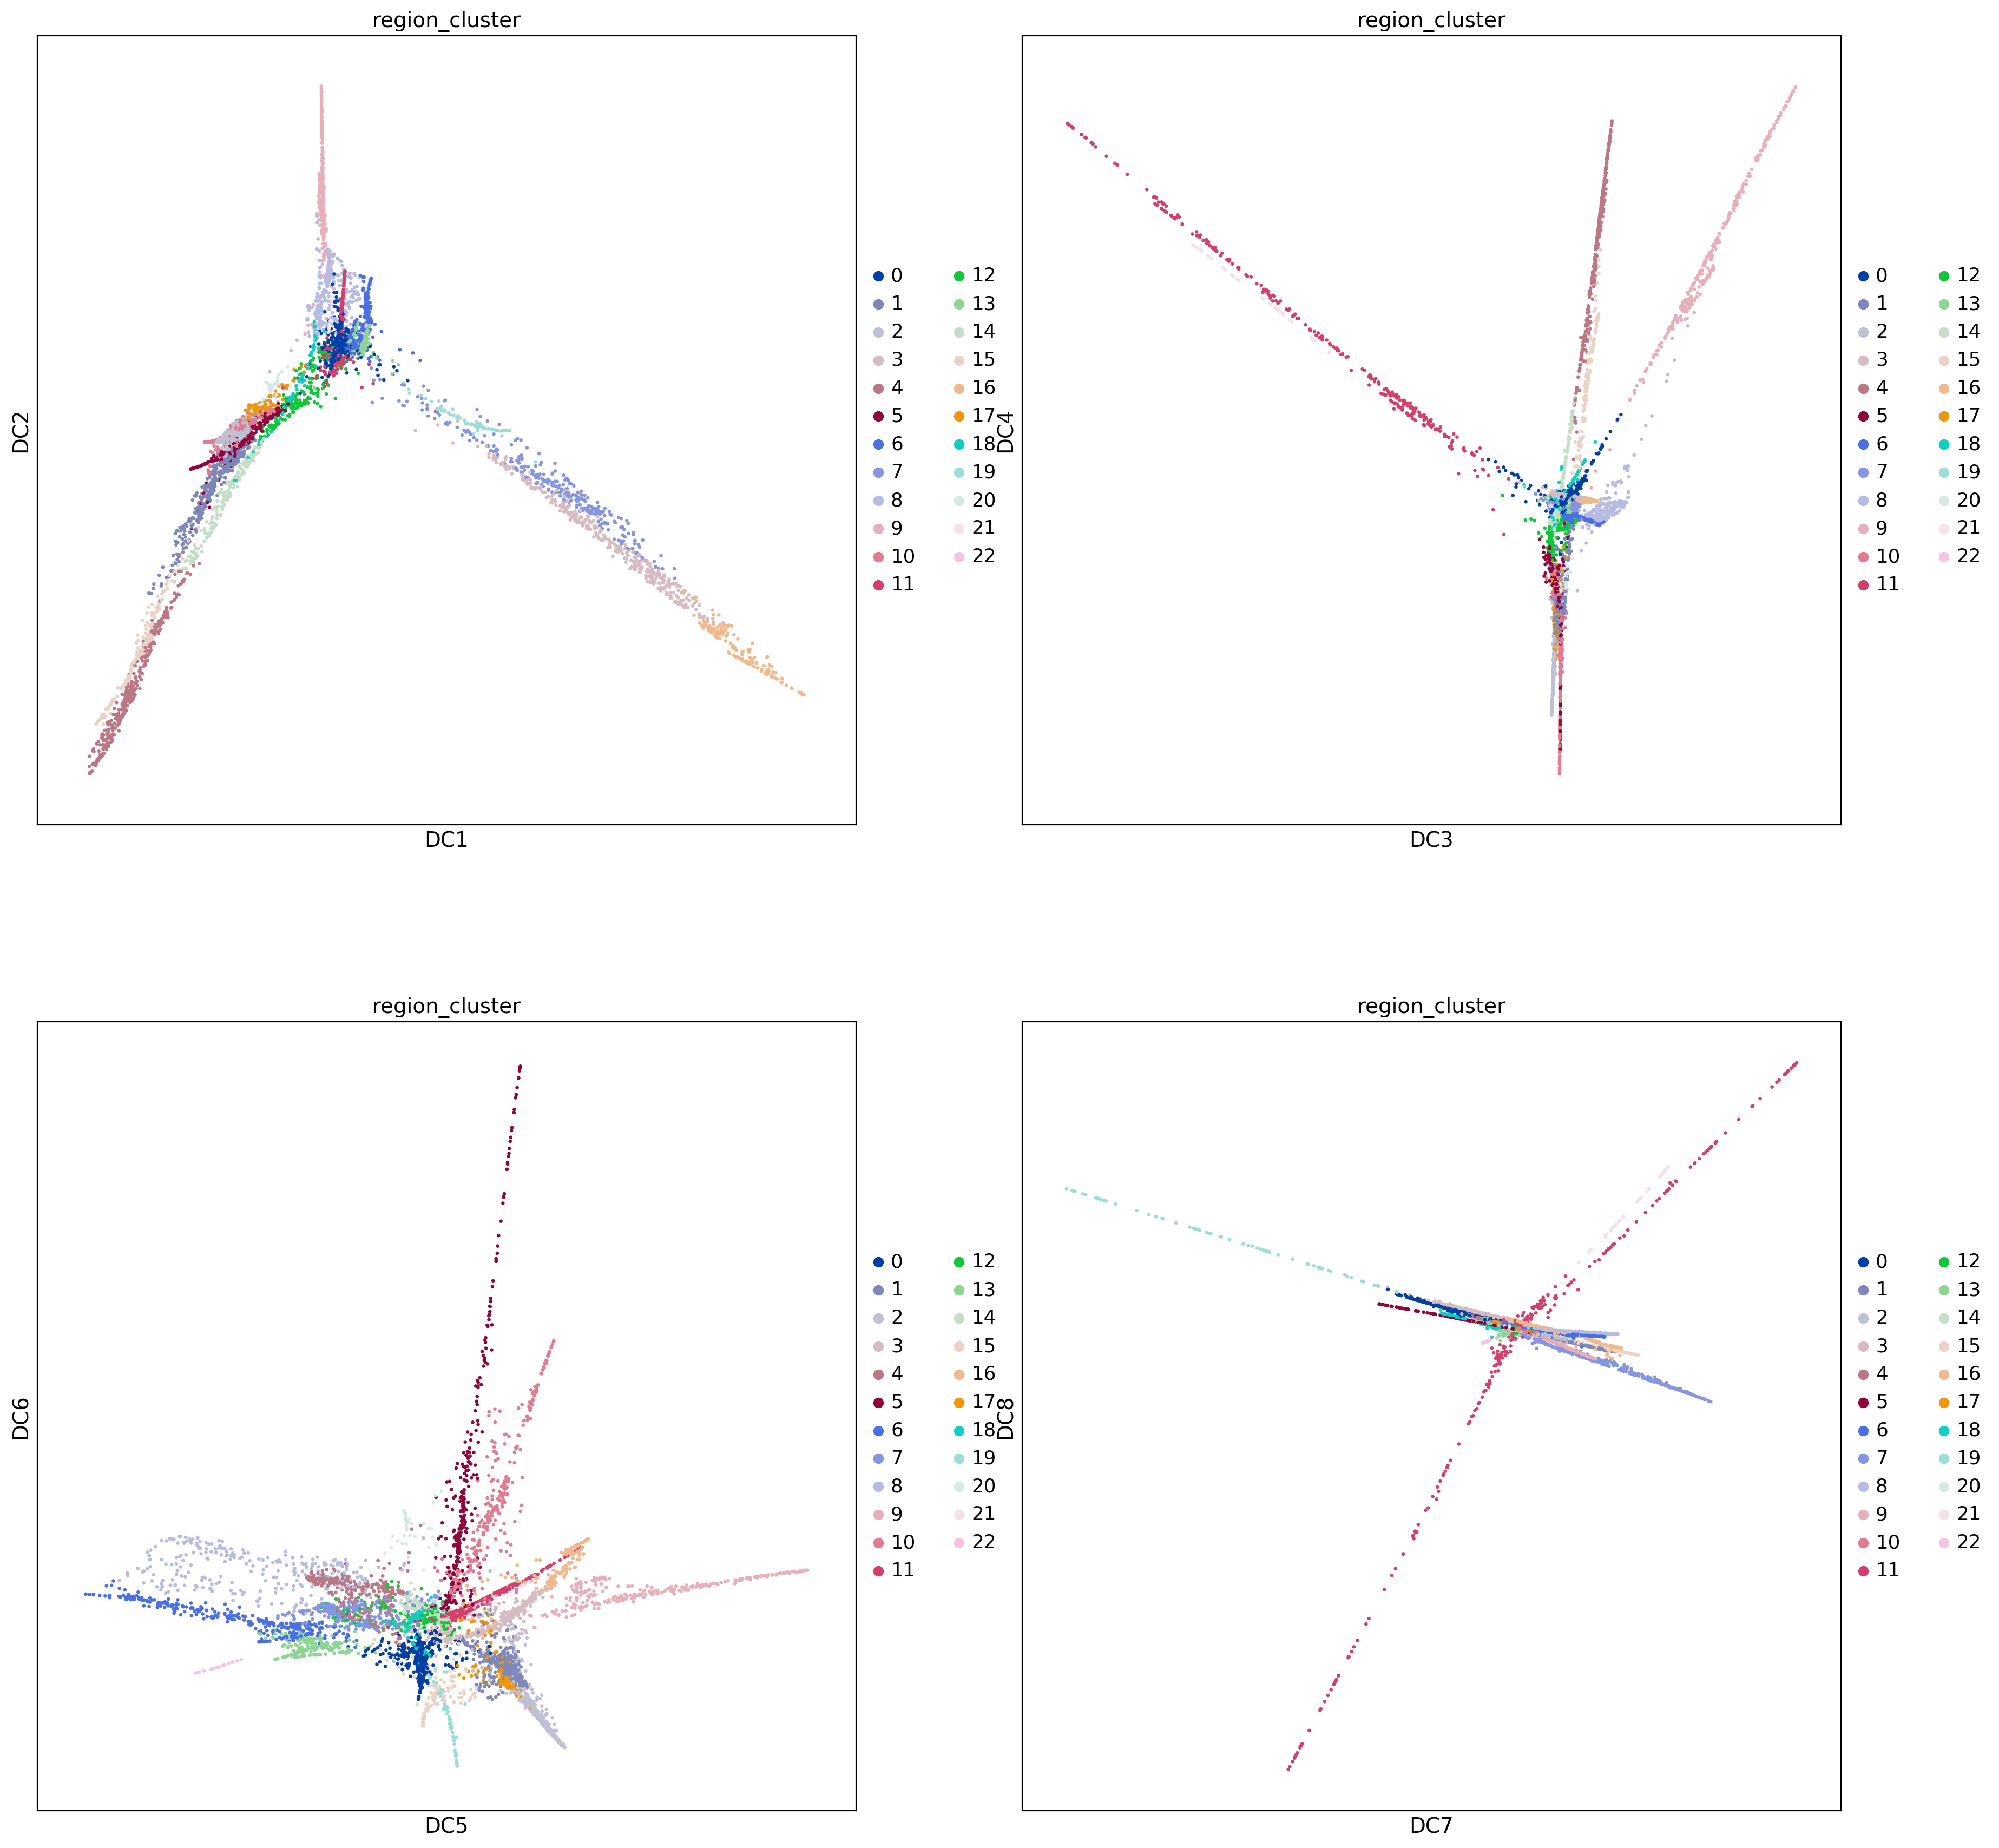

In [35]:
rcParams["axes.facecolor"] = "white"
rcParams["figure.figsize"] = [10,10]
sc.pl.diffmap(adata_vis, color=['region_cluster'],
              components=['1,2', '3,4', '5,6', '7,8'], ncols=2)

## 5. Identify co-occuring cell type combinations using matrix factorisation

Here we use inferred cell densities as input to non-negative matrix factorisation to identify co-occuring cell type combinations.

In [37]:
# number of cell type combinations - educated guess 
n_fact = int(30)

# extract cell density parameter from cell2location
X_data = adata_vis.uns['mod']['post_sample_means']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedCombination_sklearnNMF(n_fact, X_data, 
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=None,
        init='random', random_state=0, #alpha=0.1, l1_ratio=0.5,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart') 

init_1 - iterations until convergence: 2411
init_2 - iterations until convergence: 2401
init_3 - iterations until convergence: 2288
init_4 - iterations until convergence: 2347
init_5 - iterations until convergence: 2511


None
None
None
None


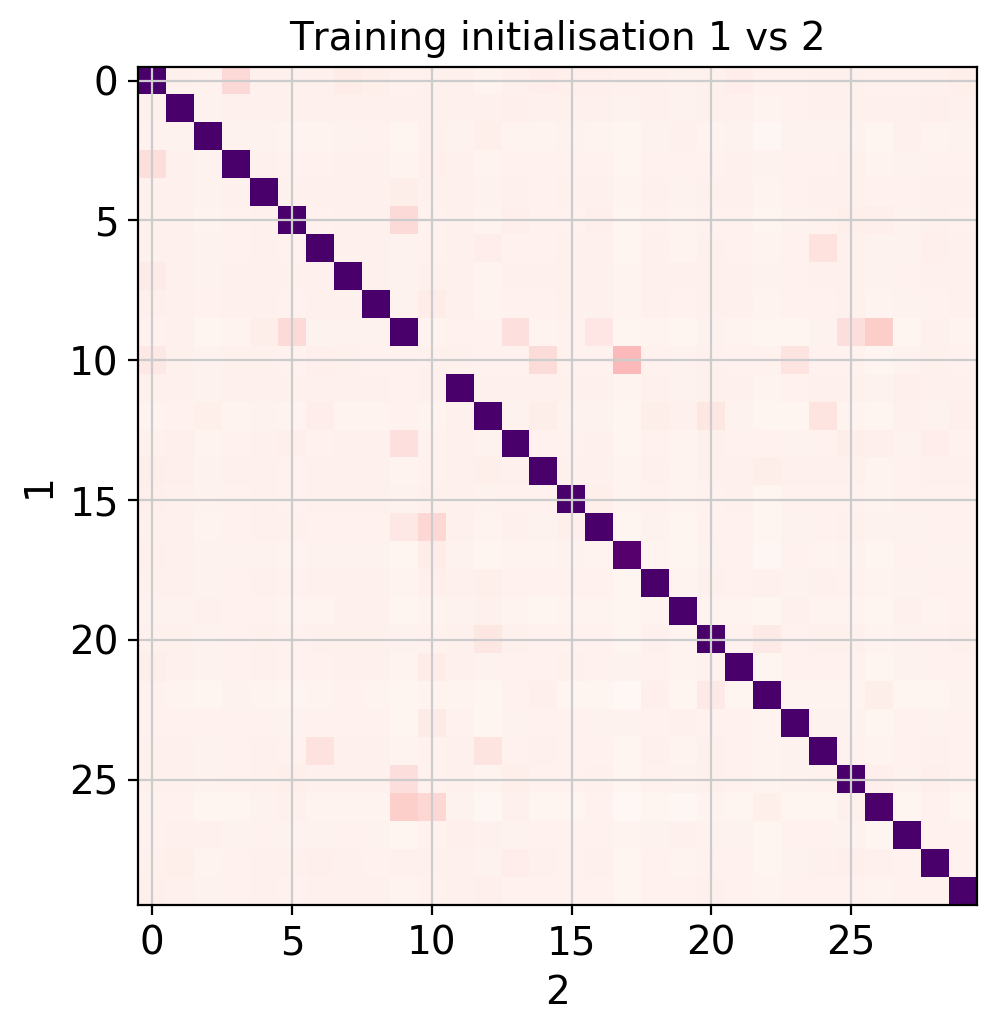

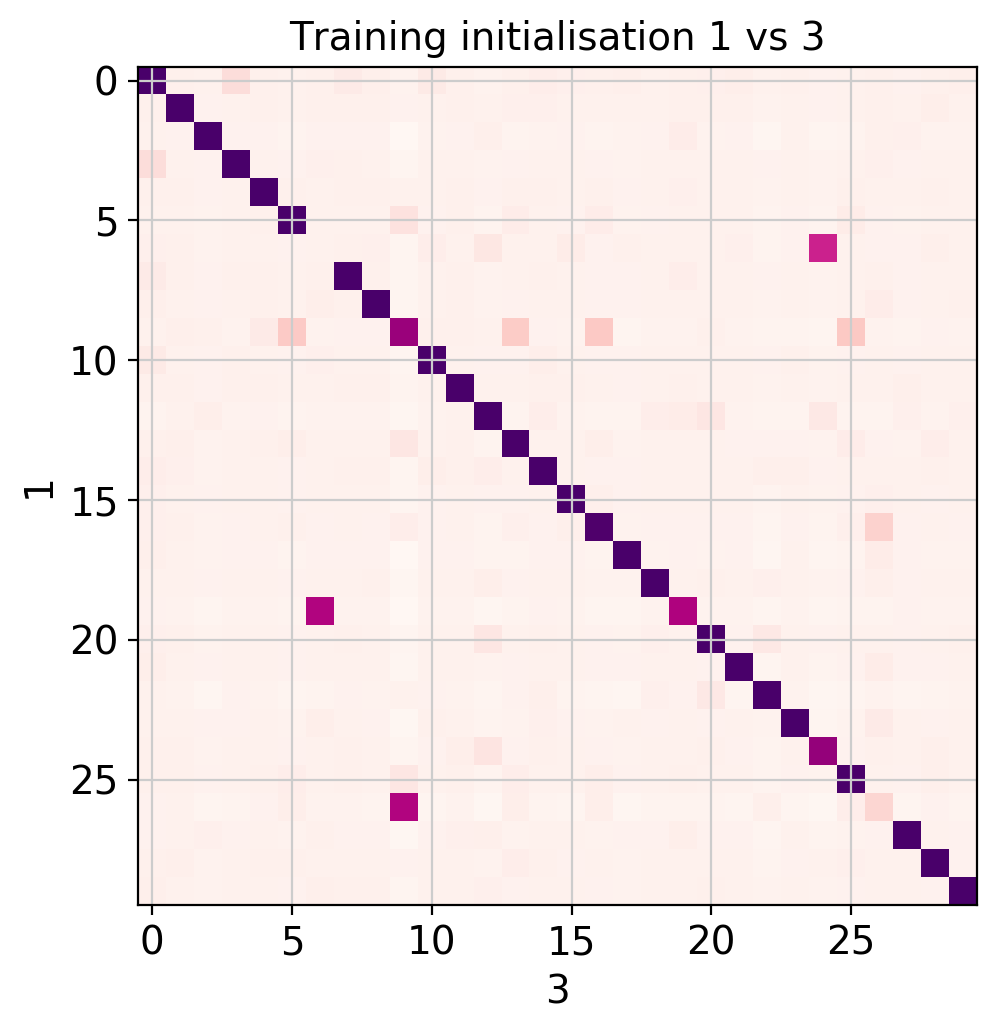

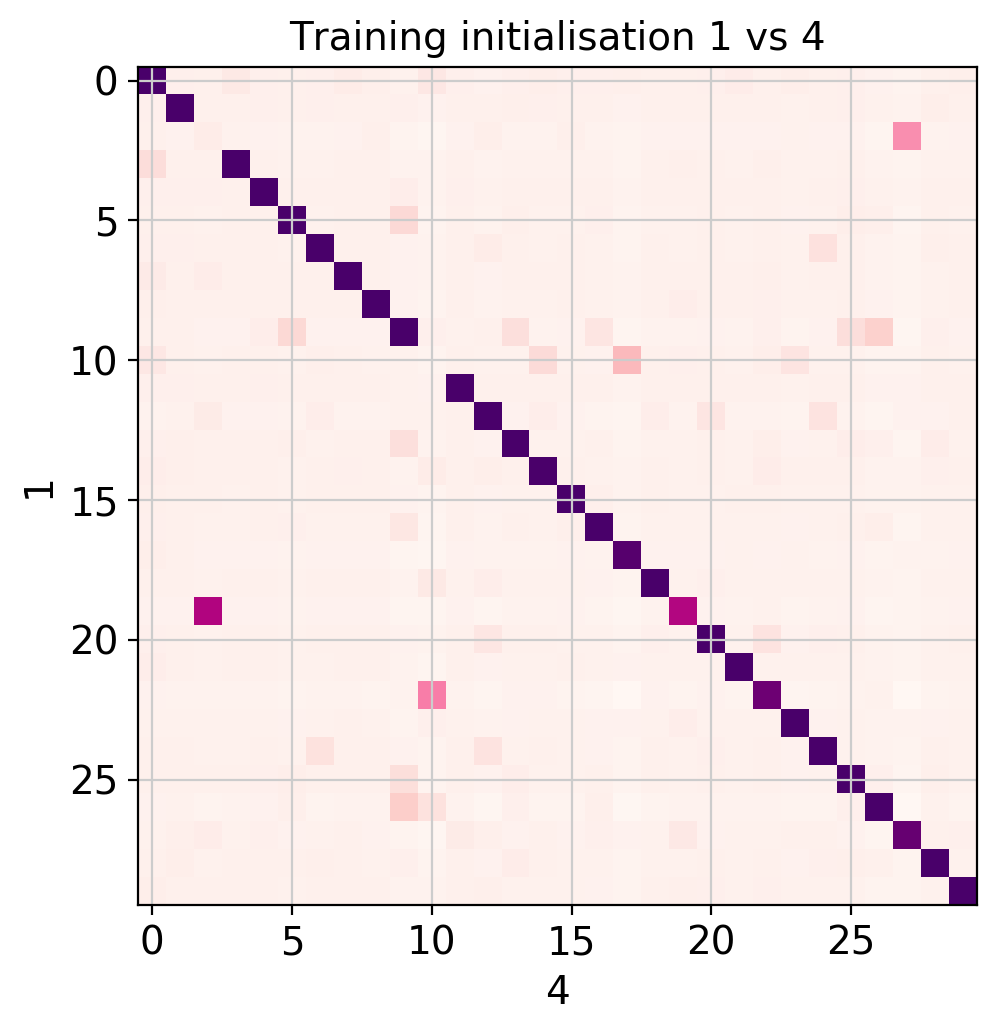

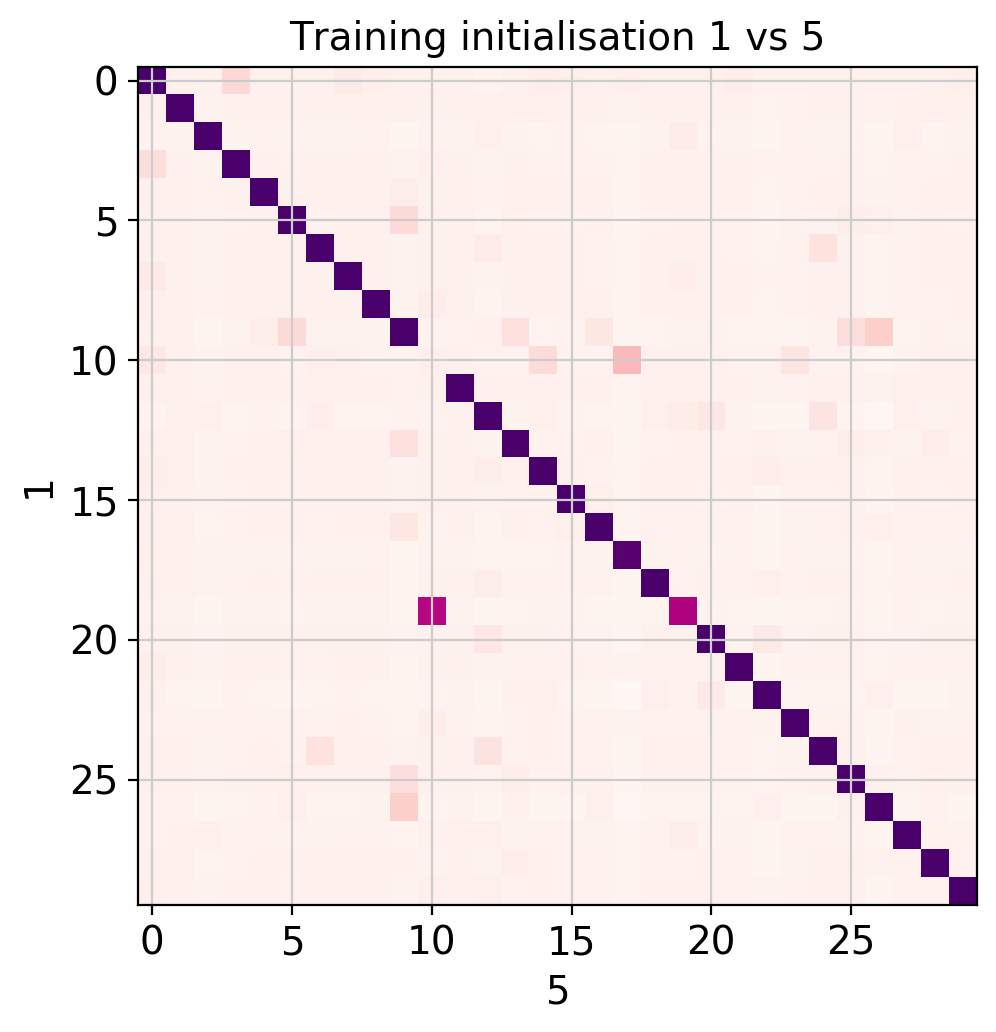

In [38]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts
rcParams["figure.figsize"] = [5.5, 5.5]
mod_sk.evaluate_stability('cell_type_factors', align=True)

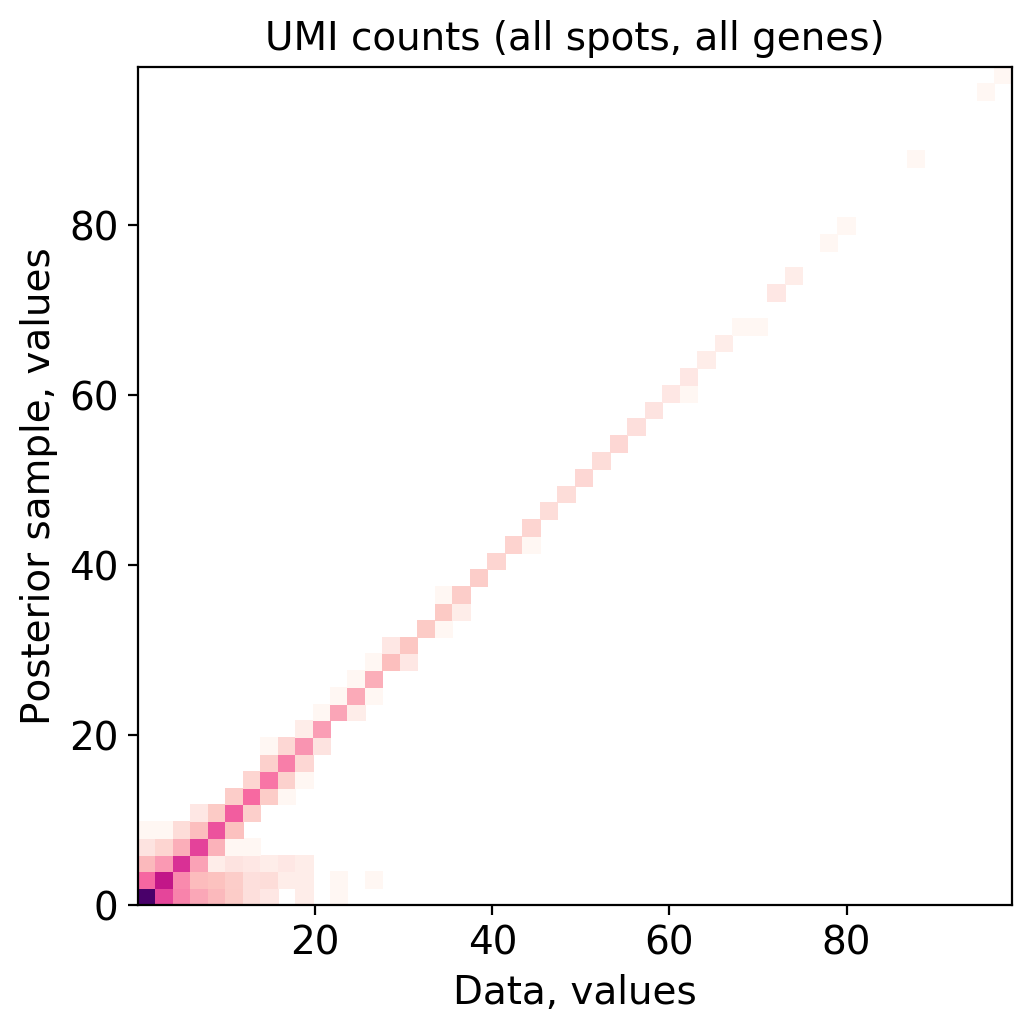

In [39]:
# evaluate accuracy of the model
rcParams["axes.facecolor"] = "white"
rcParams["figure.figsize"] = [5.5, 5.5]
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [40]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', gene_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions')

Top loadings by magnitude
---------------------
mean_cell_type_factorsfact_0:	Ext_Hpc_2, 0.98	Unk_1, 0.085	Nb_1, 0.036	Unk_2, 0.031	Inh_Lamp5, 0.029	Inh_3, 0.024	Inh_Vip, 0.015	Inh_Pvalb, 0.011	OPC_2, 0.0055	Ext_Unk_3, 0.0053
---------------------

mean_cell_type_factorsfact_1:	LowQ_1, 0.97	Endo, 0.064	Unk_2, 0.023	Inh_5, 0.018	Micro, 0.015	Nb_2, 0.011	OPC_2, 0.008	Ext_L5_2, 0.002	Inh_1, 0.00096	Astro_2, 0.00091
---------------------

mean_cell_type_factorsfact_2:	Inh_Meis2_4, 0.97	Astro_1, 0.05	Oligo_1, 0.016	Endo, 0.01	Inh_5, 0.0096	Inh_Pvalb, 0.0067	Oligo_2, 0.0054	Ext_Thal_1, 0.0034	Unk_1, 0.0016	Astro_2, 0.0011
---------------------

mean_cell_type_factorsfact_3:	Ext_Unk_2, 0.79	Astro_1, 0.64	Ext_Unk_3, 0.29	Inh_5, 0.24	Endo, 0.21	OPC_1, 0.17	Micro, 0.11	Unk_2, 0.093	Inh_Lamp5, 0.04	LowQ_2, 0.023
---------------------

mean_cell_type_factorsfact_4:	Ext_Hpc_4, 0.93	Nb_1, 0.13	Inh_Lamp5, 0.094	Inh_Vip, 0.04	Ext_Unk_3, 0.016	Ext_Hpc_3, 0.015	Endo, 0.011	Inh_Pvalb, 0.0078	OPC_1, 0.006

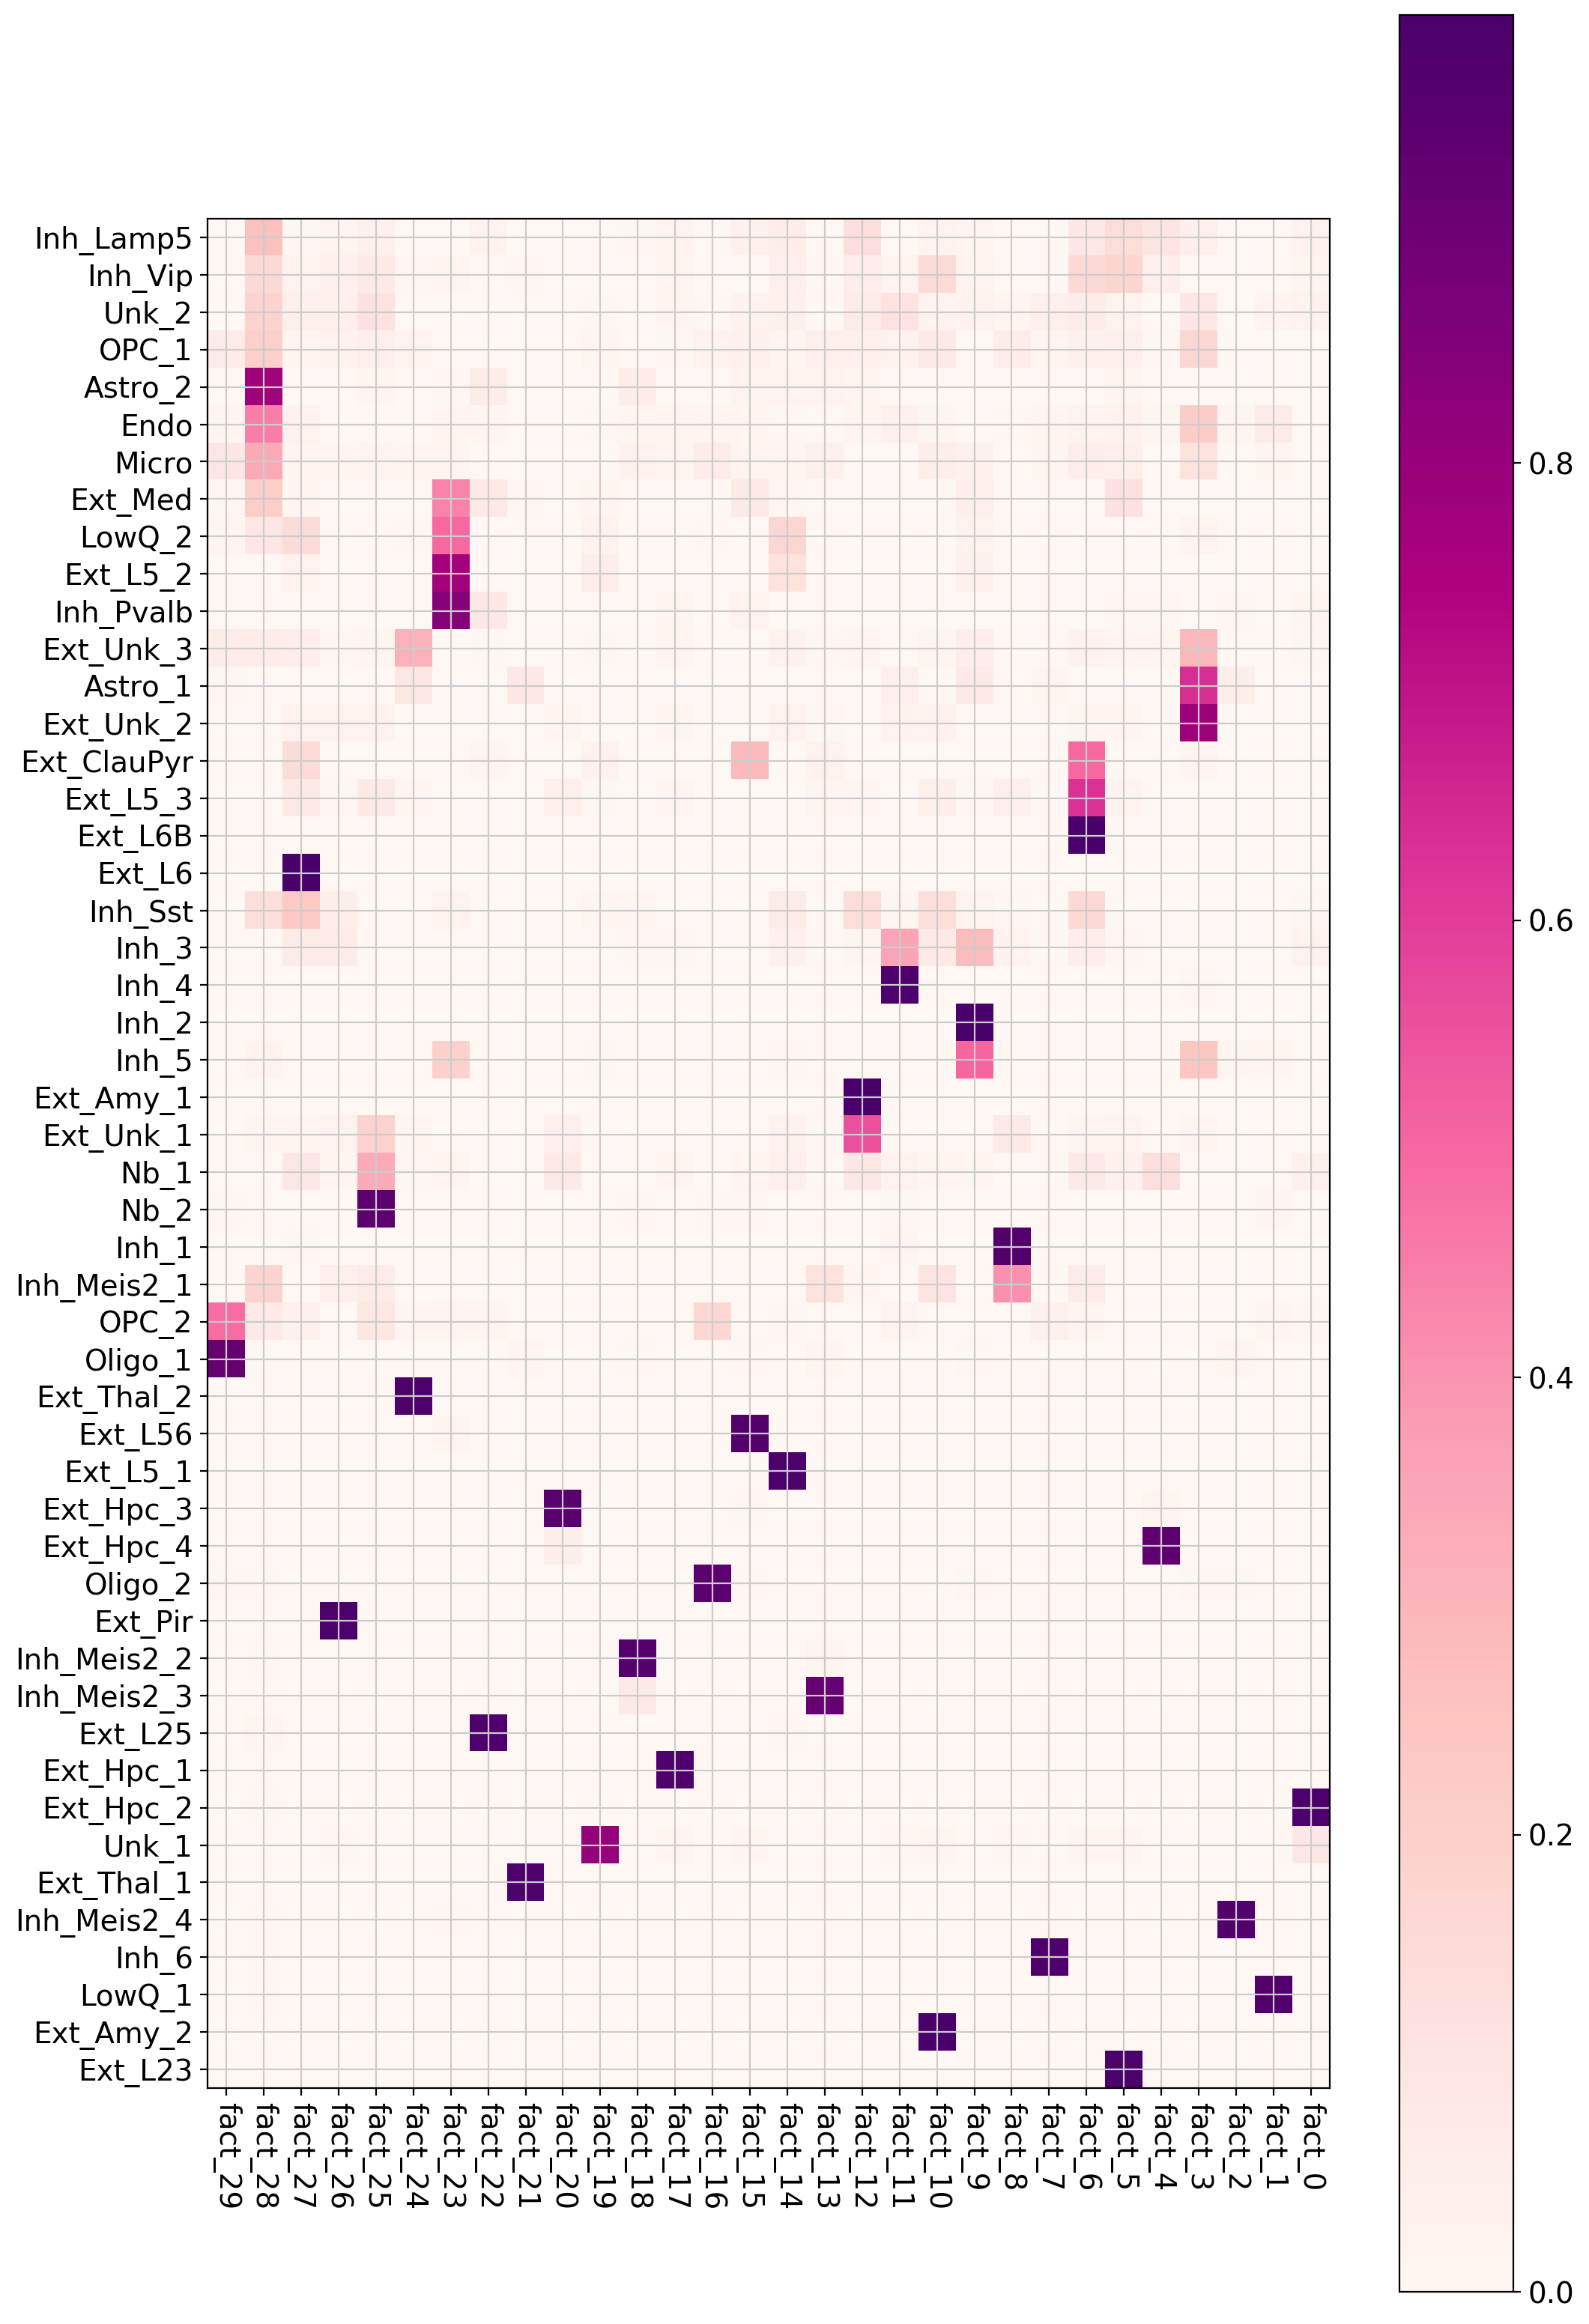

In [41]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i) 
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[12, 20])

In [ ]:
adata_vis.obs['imagecol'] = adata_vis.obsm['spatial'][:,0]
adata_vis.obs['imagerow'] = adata_vis.obsm['spatial'][:,1]
    
# Plotting spatial distribution of region factors:
import pycell2location.plt as c2lpl
import plotnine as pn
c2lpl.plot_factor_spatial(adata=adata_vis, 
                    fact_ind=np.arange(mod_sk.location_factors_df.shape[1]),
                    fact=mod_sk.location_factors_df,
                    cluster_names=mod_sk.location_factors_df.columns,
                    sample_name='ST8059048', samples_col='sample',
                    col_breaks=[0.1, 1, 10, 25], max_col=30,
                    n_columns=6, trans='log'
                   ) + pn.theme(figure_size=(21, 5))

In [43]:
# save co-location models object
def pickle_model(mod, path, file_suffix=''):
    file = path + 'model_' + str(mod.__class__.__name__) + '_' + str(mod.n_fact) + '_' + file_suffix + ".p"
    pickle.dump({'mod': mod, 'fact_names': mod.fact_names}, file = open(file, "wb"))
    print(file)
    
pickle_model(mod_sk, results_folder + 'std_model/'+r['run_name'] + '/', file_suffix='')

/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4V2_50clusters_5396locations_11945genes/model_CoLocatedCombination_sklearnNMF_30_.p


## Export results

Save resulting adata with clustering, diffusion maps and co-occuring cell type combinations.

In [44]:
adata_file = results_folder \
                + 'std_model/'+r['run_name']+'/sp_with_clusters.h5ad'
adata_vis.write(adata_file)
adata_file

'/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4V2_50clusters_5396locations_11945genes/sp_with_clusters.h5ad'

Modules and their versions used for this analysis

In [45]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.1.3
ipykernel._version 5.1.3
json 2.0.9
re 2.2.1
IPython 7.11.1
IPython.core.release 7.11.1
logging 0.5.1.2
zlib 1.0
traitlets 4.3.3
six 1.13.0
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
traitlets._version 4.3.3
decorator 4.4.1
argparse 1.1
pygments 2.5.2
pexpect 4.7.0
ptyprocess 0.6.0
pickleshare 0.7.5
backcall 0.1.0
prompt_toolkit 2.0.10
jedi 0.15.2
parso 0.5.2
urllib.request 3.7
jupyter_client 5.3.4
jupyter_client._version 5.3.4
zmq 18.1.1
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 18.1.1
zmq.sugar.constants 40302
zmq.sugar.version 18.1.1
jupyter_core 4.6.1
jupyter_core.version 4.6.1
_curses b'2.2'
dateutil 2.8.1
decimal 1.70
_decimal 1.70
distutils 3.7.6
ipywidgets 7.5.1
ipywidgets._version 7.5.1
scanpy 1.5.1
numpy 1.17.3
numpy.core 1.17.3
numpy.core._multiarray_umath 3.1
numpy.lib 1.17.3
numpy.linalg._umath_linalg b'0.1.5'
anndata 0.7.3
h5py 2.10.0
natsort 7.0.0
pandas 1.0.3
pytz 2019.3
cs